In [1]:
# =============================================================================
# 导入所有必要的库
# =============================================================================
import pandas as pd
import numpy as np
import os
import pickle
import math
import random
import itertools
import matplotlib.pyplot as plt
import optuna
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
import torch
import torch.nn as nn
from torch.amp import GradScaler, autocast
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from lifelines.utils import concordance_index
# 引入scikit-survival用于计算TD-AUC
from sksurv.metrics import cumulative_dynamic_auc

# 设置显示选项和警告过滤器
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# Section 0 & 1: Setup and Preprocessing (无需改动)
# =============================================================================
print(f"PyTorch Version: {torch.__version__}")

def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"隨機數種子已設置為: {seed_value}")

def preprocess_dataframe(df):
    df_copy = df.copy().reset_index(drop=True)
    if 'VALUE_NUMERIC' in df_copy.columns:
        df_copy['VALUE_NUMERIC'] = df_copy['VALUE_NUMERIC'].fillna(0.0)
    if 'VALUE_CATEGORICAL' in df_copy.columns:
        df_copy['VALUE_CATEGORICAL'] = df_copy['VALUE_CATEGORICAL'].fillna('Missing')
    return df_copy
    
# =============================================================================
# Sections 2-6: Model, Dataset, etc. (无需改动)
# =============================================================================
def encode_categorical_features_leakproof(train_df, val_df, categorical_cols):
    vocab_mappings = {}
    train_df_encoded = train_df.copy()
    val_df_encoded = val_df.copy()
    for col in categorical_cols:
        train_df_encoded[col] = train_df_encoded[col].astype(str)
        unique_vals = train_df_encoded[col].unique()
        vocab = {val: i + 1 for i, val in enumerate(unique_vals)}
        vocab['<PAD>'] = 0
        vocab['<UNK>'] = len(vocab)
        train_df_encoded[col + '_encoded'] = train_df_encoded[col].map(vocab)
        val_df_encoded[col + '_encoded'] = val_df_encoded[col].astype(str).map(vocab)
        val_df_encoded[col + '_encoded'].fillna(vocab['<UNK>'], inplace=True)
        vocab_mappings[col] = {'vocab': vocab, 'vocab_size': len(vocab)}
    return train_df_encoded, val_df_encoded, vocab_mappings

def normalize_numerical_features_leakproof(train_df, val_df, numerical_cols):
    scaler = StandardScaler()
    train_df_normalized = train_df.copy()
    val_df_normalized = val_df.copy()
    train_df_normalized[numerical_cols] = scaler.fit_transform(train_df[numerical_cols])
    val_df_normalized[numerical_cols] = scaler.transform(val_df[numerical_cols])
    return train_df_normalized, val_df_normalized, scaler

class PatientSequenceDataset(Dataset):
    def __init__(self, df, numerical_cols, categorical_cols_encoded, device=None):
        self.preferred_device = device
        self.sample_groups = {}
        self.sample_ids = []
        for sid, group in df.groupby('SAMPLE_ID'):
            self.sample_ids.append(sid)
            x_numerical = torch.tensor(group[numerical_cols].values, dtype=torch.float32)
            x_categorical = {
                col.replace('_encoded', ''): torch.tensor(group[col].values, dtype=torch.long)
                for col in categorical_cols_encoded
            }
            label_time = torch.tensor(group['time'].iloc[0], dtype=torch.float32)
            label_dead = torch.tensor(group['dead'].iloc[0], dtype=torch.float32)
            self.sample_groups[sid] = (x_numerical, x_categorical, (label_time, label_dead))
    
    def __len__(self):
        return len(self.sample_ids)

    def __getitem__(self, idx):
        sid = self.sample_ids[idx]
        return self.sample_groups[sid]

def collate_fn_pad(batch):
    (numericals, categoricals_list, labels) = zip(*batch)
    padded_numericals = pad_sequence(numericals, batch_first=True, padding_value=0.0)
    categorical_keys = categoricals_list[0].keys()
    categoricals_padded = {}
    for key in categorical_keys:
        sequences = [cat[key] for cat in categoricals_list]
        categoricals_padded[key] = pad_sequence(sequences, batch_first=True, padding_value=0)
    label_times, label_deads = zip(*labels)
    stacked_labels = (torch.stack(label_times), torch.stack(label_deads))
    return padded_numericals, categoricals_padded, stacked_labels

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)].transpose(0, 1)
        return self.dropout(x)

class SurvivalTransformer(nn.Module):
    def __init__(self, vocab_sizes, embedding_dims, num_numerical_features, d_model=128, nhead=8, num_encoder_layers=4, dim_feedforward=256, dropout_prob=0.5):
        super().__init__()
        self.categorical_keys = sorted(vocab_sizes.keys())
        self.embedding_layers = nn.ModuleDict({
            key: nn.Embedding(vocab_sizes[key], embedding_dims[key], padding_idx=0)
            for key in self.categorical_keys
        })
        total_embedding_dim = sum(embedding_dims.values())
        input_dim = num_numerical_features + total_embedding_dim
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout_prob)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, 
            dropout=dropout_prob, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.fc = nn.Linear(d_model, 1)
        self.d_model = d_model
    def forward(self, x_numerical, x_categorical):
        src_key_padding_mask = (x_categorical[self.categorical_keys[0]] == 0)
        embeds = [self.embedding_layers[key](x_categorical[key]) for key in self.categorical_keys]
        combined_features = torch.cat([x_numerical] + embeds, dim=2)
        projected_features = self.input_projection(combined_features) * math.sqrt(self.d_model)
        pos_encoded_features = self.pos_encoder(projected_features)
        transformer_output = self.transformer_encoder(pos_encoded_features, src_key_padding_mask=src_key_padding_mask)
        non_padding_mask = ~src_key_padding_mask
        seq_lengths = non_padding_mask.sum(dim=1, keepdim=True)
        masked_output = transformer_output * non_padding_mask.unsqueeze(-1)
        summed_output = masked_output.sum(dim=1)
        mean_output = summed_output / seq_lengths.clamp(min=1)
        risk_score = self.fc(mean_output)
        return risk_score.squeeze(1)

def cox_loss(risk_scores, times, events):
    sorted_indices = torch.argsort(times, descending=True)
    risk_scores_sorted = risk_scores[sorted_indices]
    events_sorted = events[sorted_indices]
    log_risk_set_sum = torch.log(torch.cumsum(torch.exp(risk_scores_sorted), dim=0))
    loss = -torch.sum(risk_scores_sorted[events_sorted.bool()] - log_risk_set_sum[events_sorted.bool()])
    num_events = torch.sum(events)
    if num_events > 0:
        loss = loss / num_events
    return loss
    
# =============================================================================
# Section 7: Training and Evaluation Functions (无需改动)
# =============================================================================
def train_one_epoch(model, dataloader, optimizer, loss_fn, scaler, device):
    model.train()
    total_loss = 0
    for batch_numerical_cpu, batch_categorical_cpu, (times_cpu, events_cpu) in dataloader:
        batch_numerical = batch_numerical_cpu.to(device)
        batch_categorical = {k: v.to(device) for k, v in batch_categorical_cpu.items()}
        times, events = times_cpu.to(device), events_cpu.to(device)
        
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=str(device).split(":")[0]):
            risk_scores = model(batch_numerical, batch_categorical)
            loss = loss_fn(risk_scores, times, events)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, loss_fn, device, eval_times):
    model.eval()
    total_loss = 0
    all_risk_scores, all_times, all_events = [], [], []
    
    with torch.no_grad():
        for batch_numerical, batch_categorical, (times, events) in dataloader:
            batch_numerical = batch_numerical.to(device)
            batch_categorical = {k: v.to(device) for k, v in batch_categorical.items()}
            times, events = times.to(device), events.to(device)
            
            with autocast(device_type=str(device).split(":")[0]):
                risk_scores = model(batch_numerical, batch_categorical)
                loss = loss_fn(risk_scores, times, events)
            
            total_loss += loss.item()
            all_risk_scores.append(risk_scores.cpu())
            all_times.append(times.cpu())
            all_events.append(events.cpu())

    risk_scores_raw_np = torch.cat(all_risk_scores).numpy() 
    times_np = torch.cat(all_times).numpy()
    events_np = torch.cat(all_events).numpy().astype(bool)
    
    risk_for_sksurv = risk_scores_raw_np
    risk_for_lifelines = -risk_scores_raw_np
    
    survival_train_for_auc = np.array([(e, t) for e, t in zip(events_np, times_np)], dtype=[('event', bool), ('time', float)])
    survival_test_for_auc = survival_train_for_auc
    
    c_index = concordance_index(times_np, risk_for_lifelines, events_np) 
    
    try:
        auc, mean_auc = cumulative_dynamic_auc(
            survival_train=survival_train_for_auc,
            survival_test=survival_test_for_auc,
            estimate=risk_for_sksurv, 
            times=eval_times
        )
        td_auc_results = {f"TD-AUC@{int(t)}d": auc_val for t, auc_val in zip(eval_times, auc)}
    except Exception as e:
        # print(f"  - 警告: TD-AUC 计算失败: {e}")
        td_auc_results = {f"TD-AUC@{int(t)}d": 0.0 for t in eval_times}
        mean_auc = 0.0

    return total_loss / len(dataloader), c_index, mean_auc, td_auc_results
    
# =============================================================================
# Section 8: Optuna Objective Function (参数化版本)
# =============================================================================
def objective(trial, df_for_tuning, eval_times, device):
    print(f"  [Trial {trial.number} on {device}] Starting...")
    time1 = time.time()
    # --- 1. 建议超参数 ---
    lr = trial.suggest_float('learning_rate', 1e-6, 1e-3, log=True)
    d_model = trial.suggest_categorical('d_model', [16, 32])
    nhead = trial.suggest_categorical('nhead', [2, 4])
    num_encoder_layers = trial.suggest_int('num_encoder_layers', 2, 4)
    dim_feedforward = trial.suggest_categorical('dim_feedforward', [128, 256])
    dropout = trial.suggest_float('dropout', 0.4, 0.7)
    weight_decay = trial.suggest_float('weight_decay', 5e-5, 5e-3, log=True)

    if d_model % nhead != 0:
        raise optuna.exceptions.TrialPruned()
    
    # --- 3. 5折交叉驗證 ---
    patient_ids = df_for_tuning['PATIENT_ID'].unique()
    kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    fold_metrics = []
    
    # 【修正】为每个指标创建独立的列表
    fold_val_losses = []
    fold_val_iaucs = []
    fold_val_cindex = [] # <--- 已有，是正确的
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(patient_ids)):
        print("="*30)
        print(f"    [Trial {trial.number} on {device}] Fold {fold+1}/{N_SPLITS}...")
        
        train_patient_ids = patient_ids[train_idx]
        val_patient_ids = patient_ids[val_idx]
        
        train_df_fold = df_for_tuning[df_for_tuning['PATIENT_ID'].isin(train_patient_ids)]
        val_df_fold = df_for_tuning[df_for_tuning['PATIENT_ID'].isin(val_patient_ids)]
        
        train_df_encoded, val_df_encoded, vocabs = encode_categorical_features_leakproof(train_df_fold, val_df_fold, final_categorical_cols)
        train_df_norm, val_df_norm, _ = normalize_numerical_features_leakproof(train_df_encoded, val_df_encoded, final_standardize_cols)
        
        train_dataset = PatientSequenceDataset(train_df_norm, final_numerical_cols, categorical_cols_encoded)
        val_dataset = PatientSequenceDataset(val_df_norm, final_numerical_cols, categorical_cols_encoded)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad, pin_memory=True)
        
        vocab_sizes = {k: v['vocab_size'] for k, v in vocabs.items()}
        model = SurvivalTransformer(
            vocab_sizes=vocab_sizes,
            embedding_dims=embedding_dims, 
            num_numerical_features=len(final_numerical_cols), 
            d_model=d_model, 
            nhead=nhead, 
            num_encoder_layers=num_encoder_layers, 
            dim_feedforward=dim_feedforward, 
            dropout_prob=dropout
        ).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, fused=True)
        scaler = GradScaler()
        
        best_val_metric = -1.0
        patience_counter = 0
        
        # 【修正】为每个指标创建独立的当前折叠历史列表
        current_fold_val_losses = []
        current_fold_val_iaucs = []
        current_fold_val_cindex = [] # <--- 已有，是正确的
        
        for epoch in range(NUM_EPOCHS_TUNE):
            train_one_epoch(model, train_loader, optimizer, cox_loss, scaler, device)
            val_loss, val_c, val_iauc, _ = evaluate_model(model, val_loader, cox_loss, device, eval_times)
            current_metric = val_iauc
            
            # 【【【【【 核心修正 】】】】】
            # 将每个指标添加到它自己专属的列表中
            current_fold_val_losses.append(val_loss)
            current_fold_val_iaucs.append(val_iauc)
            current_fold_val_cindex.append(val_c) # <--- 正确地添加到 cindex 列表
            
            if current_metric > best_val_metric:
                best_val_metric = current_metric
                patience_counter = 0
            else:
                patience_counter += 1
                
            if (epoch + 1) % 10 == 0:
                 print(f"  Epoch {epoch+1}, Loss: {val_loss:.4f}, C-Index: {val_c:.4f}, iAUC: {val_iauc:.4f}, Patience: {patience_counter}/{PATIENCE}")

            if patience_counter >= PATIENCE:
                break
        
        fold_metrics.append(best_val_metric)
        # 【修正】将每个当前折叠的历史添加到总历史列表中
        fold_val_losses.append(current_fold_val_losses)
        fold_val_iaucs.append(current_fold_val_iaucs)
        fold_val_cindex.append(current_fold_val_cindex) # <--- 正确

    mean_val_metric = np.mean(fold_metrics)
    time2 = time.time()
    print(f"  [Trial {trial.number} on {device}] Finished in {time2 - time1:.2f}s. Mean Val iAUC: {mean_val_metric:.5f}")
    
    # 【新增】绘图部分
    plot_dir = "./plot"
    os.makedirs(plot_dir, exist_ok=True)
    trial_plot_dir = os.path.join(plot_dir, f"Trial {trial.number}")
    os.makedirs(trial_plot_dir, exist_ok=True)

    for fold_idx in range(N_SPLITS):
        epochs_range = range(1, len(fold_val_losses[fold_idx]) + 1)
        
        # 【【【【【 核心修正 2 】】】】】
        # 你需要创建三个子图，或者将两个指标画在同一个图上
        # 这里我们创建三个子图，让每个指标都有自己的y轴
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 5))
        
        # Loss曲线
        ax1.plot(epochs_range, fold_val_losses[fold_idx], label='Validation Loss', color='blue')
        ax1.set_title(f'Fold {fold_idx+1} Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Cox Loss')
        ax1.legend()
        ax1.grid(True)
        
        # iAUC曲线
        ax2.plot(epochs_range, fold_val_iaucs[fold_idx], label='Validation iAUC', color='red')
        ax2.set_title(f'Fold {fold_idx+1} iAUC Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('iAUC')
        ax2.legend()
        ax2.grid(True)

        # C-Index曲线
        # 【【【【【 核心修正 3 】】】】】
        # 使用正确的变量名 `fold_val_cindex`
        ax3.plot(epochs_range, fold_val_cindex[fold_idx], label='Validation C-Index', color='green')
        ax3.set_title(f'Fold {fold_idx+1} C-Index Curve')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('C-Index')
        ax3.legend()
        ax3.grid(True)
        
        plt.suptitle(f'Trial {trial.number} Performance on {device}')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(os.path.join(trial_plot_dir, f"fold_{fold_idx+1}_performance.png"))
        plt.close(fig)
        
    print(f"  [Trial {trial.number} on {device}] Plots saved to {trial_plot_dir}")

    return mean_val_metric

# =============================================================================
# Section 9: Final Model Training Function (参数化版本)
# =============================================================================
def train_final_model_and_plot(best_params, df_train, df_test, eval_times, device):
    print(f"\n--- 步骤 4: 在 {device} 上训练最终模型并评估 ---")
    
    train_df_encoded, test_df_encoded, vocabs = encode_categorical_features_leakproof(df_train, df_test, final_categorical_cols)
    train_df_norm, test_df_norm, scaler = normalize_numerical_features_leakproof(train_df_encoded, test_df_encoded, final_standardize_cols)

    train_dataset = PatientSequenceDataset(train_df_norm, final_numerical_cols, categorical_cols_encoded)
    test_dataset = PatientSequenceDataset(test_df_norm, final_numerical_cols, categorical_cols_encoded)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad)

    vocab_sizes = {k: v['vocab_size'] for k, v in vocabs.items()}
    model = SurvivalTransformer(
        vocab_sizes=vocab_sizes, 
        embedding_dims=embedding_dims, 
        num_numerical_features=len(final_numerical_cols),
        d_model=best_params['d_model'], 
        nhead=best_params['nhead'], 
        num_encoder_layers=best_params['num_encoder_layers'], 
        dim_feedforward=best_params['dim_feedforward'], 
        dropout_prob=best_params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'], fused=True)
    grad_scaler = GradScaler()
    
    history = {'train_loss': [], 'test_loss': [], 'train_c': [], 'test_c': []}
    
    for epoch in range(NUM_EPOCHS_FINAL):
        train_loss = train_one_epoch(model, train_loader, optimizer, cox_loss, grad_scaler, device)
        train_loss_eval, train_c, _, _ = evaluate_model(model, train_loader, cox_loss, device, eval_times)
        test_loss, test_c, test_iauc, test_td_auc_detailed = evaluate_model(model, test_loader, cox_loss, device, eval_times)
        
        history['train_loss'].append(train_loss_eval)
        history['test_loss'].append(test_loss)
        history['train_c'].append(train_c)
        history['test_c'].append(test_c)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS_FINAL} | "
                  f"Train Loss: {train_loss_eval:.4f}, Test Loss: {test_loss:.4f} | "
                  f"Train C-Idx: {train_c:.4f}, Test C-Idx: {test_c:.4f}")

    print("\n--- 最终模型在独立测试集上的性能 ---")
    print(f"  - 最终测试集 C-Index: {test_c:.4f}")
    print(f"  - 最终测试集 iAUC: {test_iauc:.4f}")
    for k, v in test_td_auc_detailed.items():
        print(f"    - {k}: {v:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs = range(1, NUM_EPOCHS_FINAL + 1)

    ax1.plot(epochs, history['train_loss'], label='Train Loss')
    ax1.plot(epochs, history['test_loss'], label='Test Loss')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Cox Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_c'], label='Train C-Index')
    ax2.plot(epochs, history['test_c'], label='Test C-Index')
    ax2.set_title('C-Index Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('C-Index')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle('Model Train History')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("final_model_training_history.png")
    print("\n训练历史图表已保存至 'final_model_training_history.png'")
    plt.show()

# =============================================================================
# Section 10: Main Execution Block (Jupyter Notebook版)
# =============================================================================

# ---------------------------------------------------------------------------
# 【【【【【 关键控制区 】】】】】
#  在第一个笔记本中，设置为 0。在第二个笔记本中，设置为 1。
GPU_ID = 0  
# ---------------------------------------------------------------------------

# --- 主程序开始 ---
time_start = time.time()
SEED = 42
set_seed(SEED)

# --- 0. 用户配置 ---
DEVICE = f"cuda:{GPU_ID}"
print(f"####################################################")
print(f"###   本笔记本将运行在主设备: {DEVICE}   ###")
print(f"####################################################\n")

# --- 假设数据文件 'df_brca_landmarks.csv' 在同一目录下 ---
if not os.path.exists('df_prostate_landmarks.csv'):
    print("错误: 未找到数据文件 'df_brca_landmarks.csv'。请将数据文件放在与笔记本相同的目录中。")
else:
    ALL_FEATURES = [
        'START_DATE', 'VALUE_NUMERIC', 'EVENT_DURATION', 
        'EVENT_TYPE', 'EVENT_SUBTYPE', 'VALUE_CATEGORICAL', 
        'AGE', 'BLACK', 'STAGE 4', 'PTEN', 'TP53'
    ]
    STANDARDIZE_COLS = ['START_DATE', 'EVENT_DURATION', 'VALUE_NUMERIC', 'AGE']
    CATEGORICAL_COLS = ['EVENT_TYPE', 'EVENT_SUBTYPE', 'VALUE_CATEGORICAL']
    embedding_dims = {'EVENT_TYPE': 8, 'EVENT_SUBTYPE': 10, 'VALUE_CATEGORICAL': 12}

    TEST_SET_SIZE = 0.3
    BATCH_SIZE = 128
    N_SPLITS = 3      # 交叉验证折数
    PATIENCE = 5      # 早停耐心值
    NUM_EPOCHS_TUNE = 60 # Optuna 内部训练的最大轮数
    NUM_EPOCHS_FINAL = 80 # 最终模型训练轮数
    
    # 【重要】设置每个GPU（笔记本）要运行的试验次数
    # 如果总共想跑20次，你有2个GPU，这里就设置为10
    N_TRIALS_PER_GPU = 15 

    # --- 1. 数据加载与初步处理 ---
    print("--- 步骤 1: 加载和准备数据 ---")
    df_full = pd.read_csv('df_crc_landmarks.csv')

    EVALUATION_TIMES = np.array([365, 730, 1095, 1460, 1825]) 
    existing_features = [f for f in ALL_FEATURES if f in df_full.columns]
    df_processed = preprocess_dataframe(df_full[['SAMPLE_ID', 'PATIENT_ID', 'entry', 'stop', 'dead', 'time'] + existing_features])

    final_categorical_cols = [c for c in CATEGORICAL_COLS if c in df_processed.columns]
    final_numerical_cols = sorted(list(set(existing_features) - set(final_categorical_cols)))
    final_standardize_cols = [c for c in STANDARDIZE_COLS if c in final_numerical_cols]
    categorical_cols_encoded = [c + '_encoded' for c in final_categorical_cols]

    # --- 2. 最终测试集划分 ---
    print(f"\n--- 步骤 2: 划分训练集 ({1-TEST_SET_SIZE:.0%}) 和最终测试集 ({TEST_SET_SIZE:.0%}) ---")
    all_patient_ids = df_processed['PATIENT_ID'].unique()
    train_patient_ids, test_patient_ids = train_test_split(all_patient_ids, test_size=TEST_SET_SIZE, random_state=SEED)
    df_train = df_processed[df_processed['PATIENT_ID'].isin(train_patient_ids)].copy()
    df_test = df_processed[df_processed['PATIENT_ID'].isin(test_patient_ids)].copy()
    print(f"训练集患者数: {len(train_patient_ids)}, 测试集患者数: {len(test_patient_ids)}")

    # --- 3. 运行Optuna进行超参数搜索 ---
    print(f"\n--- 步骤 3: 使用Optuna进行超参数搜索 (本进程贡献自 {DEVICE}) ---")
    db_name = "optuna_parallel_study.db"
    storage_name = f"sqlite:///{db_name}"
    study_name = "survival_study_jupyter"

    if GPU_ID == 0 and os.path.exists(db_name):
        print(f"由主进程({DEVICE})检测到旧数据库，正在删除: {db_name}")
        os.remove(db_name)
    
    # 在开始前稍作等待，确保主进程完成删除操作
    time.sleep(2)

    study = optuna.create_study(
        study_name=study_name,
        storage=storage_name,
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(),
        load_if_exists=True
    )

    study.optimize(
        lambda trial: objective(trial, df_train, EVALUATION_TIMES, DEVICE),
        n_trials=N_TRIALS_PER_GPU 
    )

    print(f"\n--- 进程 {DEVICE} 的 {N_TRIALS_PER_GPU} 次 Optuna 试验已完成 ---")

    # --- 4. 使用最佳参数训练最终模型并评估 (仅由主进程执行) ---
    if GPU_ID == 0:
        # 等待所有其他进程完成
        print("\n\n==========================================================")
        print("=== 主进程({DEVICE})等待其他进程完成... ===")
        print("==========================================================")
        
        # 检查study状态，直到达到总试验次数
        total_trials_expected = N_TRIALS_PER_GPU * torch.cuda.device_count() # 假设使用所有GPU
        while len(study.get_trials()) < total_trials_expected:
            print(f"当前完成 {len(study.get_trials())}/{total_trials_expected} trials. 等待30秒...")
            time.sleep(30)
        
        # 重新加载study以获取所有笔记本的最新结果
        study = optuna.load_study(
            study_name=study_name,
            storage=storage_name
        )
        
        print("\n--- Optuna 全局搜索完成 ---")
        print(f"数据库中的总试验次数: {len(study.trials)}")
        print(f"最佳试验 (iAUC): {study.best_value:.5f}")
        print("最佳超参数:")
        for key, value in study.best_params.items():
            print(f"  {key}: {value}")
        
        optuna_results_df = study.trials_dataframe()
        optuna_results_df.to_csv("optuna_search_results.csv", index=False)
        print("\n所有Optuna试验的详细结果已保存至 'optuna_search_results.csv'")

        # 在主设备(GPU 0)上训练最终模型
        train_final_model_and_plot(study.best_params, df_train, df_test, EVALUATION_TIMES, DEVICE)

        time_end = time.time()
        print(f"\n脚本总执行时间: {(time_end - time_start) / 60:.2f} 分钟")

PyTorch Version: 2.5.1+cu124
隨機數種子已設置為: 42
####################################################
###   本笔记本将运行在主设备: cuda:0   ###
####################################################

--- 步骤 1: 加载和准备数据 ---

--- 步骤 2: 划分训练集 (70%) 和最终测试集 (30%) ---
训练集患者数: 3479, 测试集患者数: 1492

--- 步骤 3: 使用Optuna进行超参数搜索 (本进程贡献自 cuda:0) ---
由主进程(cuda:0)检测到旧数据库，正在删除: optuna_parallel_study.db


KeyboardInterrupt: 

In [6]:
NUM_EPOCHS_FINAL = 120
def train_final_model_and_plot(best_params, df_train, df_test, eval_times, device):
    print(f"\n--- 步骤 4: 在 {device} 上训练最终模型并评估 ---")
    
    train_df_encoded, test_df_encoded, vocabs = encode_categorical_features_leakproof(df_train, df_test, final_categorical_cols)
    train_df_norm, test_df_norm, scaler = normalize_numerical_features_leakproof(train_df_encoded, test_df_encoded, final_standardize_cols)

    train_dataset = PatientSequenceDataset(train_df_norm, final_numerical_cols, categorical_cols_encoded)
    test_dataset = PatientSequenceDataset(test_df_norm, final_numerical_cols, categorical_cols_encoded)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn_pad)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn_pad)

    vocab_sizes = {k: v['vocab_size'] for k, v in vocabs.items()}
    model = SurvivalTransformer(
        vocab_sizes=vocab_sizes, 
        embedding_dims=embedding_dims, 
        num_numerical_features=len(final_numerical_cols),
        d_model=best_params['d_model'], 
        nhead=best_params['nhead'], 
        num_encoder_layers=best_params['num_encoder_layers'], 
        dim_feedforward=best_params['dim_feedforward'], 
        dropout_prob=best_params['dropout']
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'], fused=True)
    grad_scaler = GradScaler()
    
    history = {'train_loss': [], 'test_loss': [], 'train_c': [], 'test_c': []}
    
    for epoch in range(NUM_EPOCHS_FINAL):
        train_loss = train_one_epoch(model, train_loader, optimizer, cox_loss, grad_scaler, device)
        train_loss_eval, train_c, _, _ = evaluate_model(model, train_loader, cox_loss, device, eval_times)
        test_loss, test_c, test_iauc, test_td_auc_detailed = evaluate_model(model, test_loader, cox_loss, device, eval_times)
        
        history['train_loss'].append(train_loss_eval)
        history['test_loss'].append(test_loss)
        history['train_c'].append(train_c)
        history['test_c'].append(test_c)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:03d}/{NUM_EPOCHS_FINAL} | "
                  f"Train Loss: {train_loss_eval:.4f}, Test Loss: {test_loss:.4f} | "
                  f"Train C-Idx: {train_c:.4f}, Test C-Idx: {test_c:.4f}")

    print("\n--- 最终模型在独立测试集上的性能 ---")
    print(f"  - 最终测试集 C-Index: {test_c:.4f}")
    print(f"  - 最终测试集 iAUC: {test_iauc:.4f}")
    for k, v in test_td_auc_detailed.items():
        print(f"    - {k}: {v:.4f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs = range(1, NUM_EPOCHS_FINAL + 1)

    ax1.plot(epochs, history['train_loss'], label='Train Loss')
    ax1.plot(epochs, history['test_loss'], label='Test Loss')
    ax1.set_title('Loss Curve')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Cox Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(epochs, history['train_c'], label='Train C-Index')
    ax2.plot(epochs, history['test_c'], label='Test C-Index')
    ax2.set_title('C-Index Curve')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('C-Index')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle('Model Train History')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("final_model_training_history.png")
    print("\n训练历史图表已保存至 'final_model_training_history.png'")
    plt.show()


--- 步骤 4: 在 cuda:0 上训练最终模型并评估 ---
Epoch 010/120 | Train Loss: 4.1450, Test Loss: 4.4529 | Train C-Idx: 0.6491, Test C-Idx: 0.6365
Epoch 020/120 | Train Loss: 3.9948, Test Loss: 4.3085 | Train C-Idx: 0.7303, Test C-Idx: 0.7082
Epoch 030/120 | Train Loss: 3.8691, Test Loss: 4.1892 | Train C-Idx: 0.7355, Test C-Idx: 0.7168
Epoch 040/120 | Train Loss: 3.8319, Test Loss: 4.1566 | Train C-Idx: 0.7414, Test C-Idx: 0.7243
Epoch 050/120 | Train Loss: 3.8396, Test Loss: 4.1367 | Train C-Idx: 0.7518, Test C-Idx: 0.7355
Epoch 060/120 | Train Loss: 3.8077, Test Loss: 4.1021 | Train C-Idx: 0.7632, Test C-Idx: 0.7477
Epoch 070/120 | Train Loss: 3.7705, Test Loss: 4.0651 | Train C-Idx: 0.7731, Test C-Idx: 0.7587
Epoch 080/120 | Train Loss: 3.7356, Test Loss: 4.0320 | Train C-Idx: 0.7814, Test C-Idx: 0.7679
Epoch 090/120 | Train Loss: 3.7160, Test Loss: 4.0096 | Train C-Idx: 0.7878, Test C-Idx: 0.7748
Epoch 100/120 | Train Loss: 3.7011, Test Loss: 3.9987 | Train C-Idx: 0.7926, Test C-Idx: 0.7799
Epoch

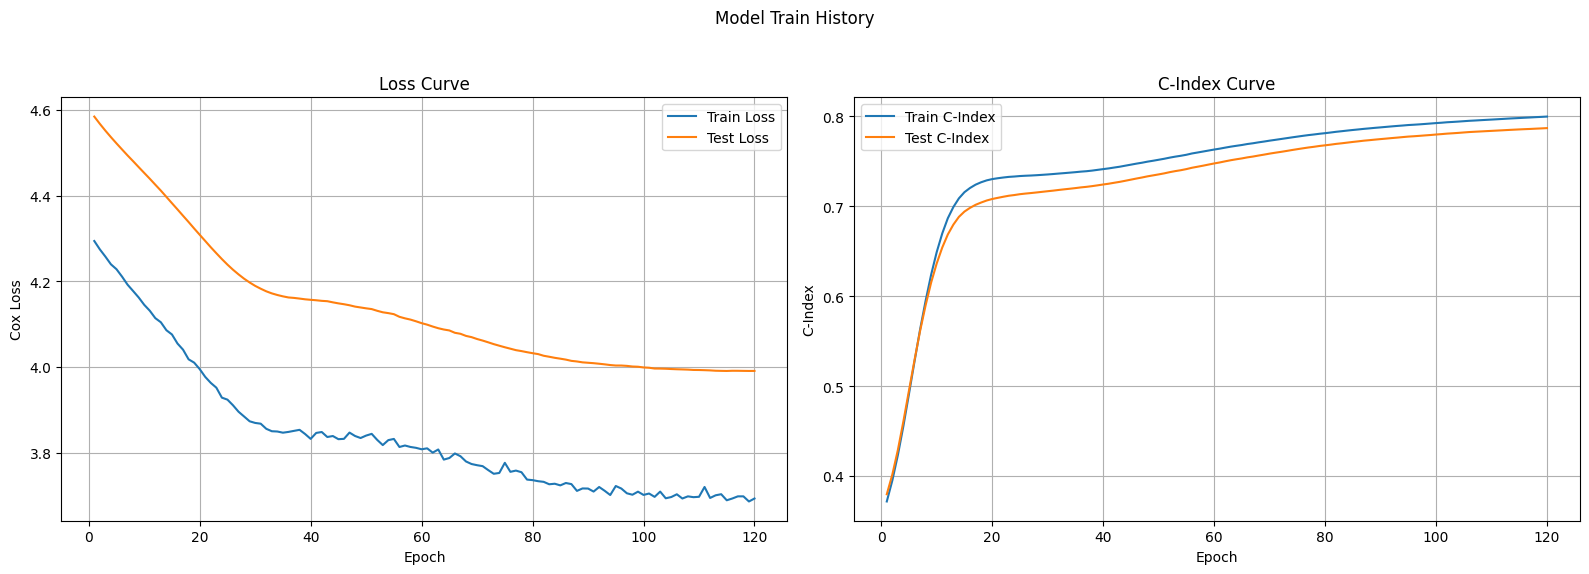

In [7]:
params_selected_10 = {
    'learning_rate': 4.08041701166579E-06,
    'd_model': 32,
    'nhead': 4,
    'num_encoder_layers': 2,
    'dim_feedforward': 128,
    'dropout': 0.541624952,
    'weight_decay': 0.001491843
}
train_final_model_and_plot(params_selected_10, df_train, df_test, EVALUATION_TIMES, DEVICE)